# PCA

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 13.01.2023
- **Date of Last Modification:** 13.01.2023

- Run PCA on log-normalized counts to get a baseline latent representation.

## 1. Setup

### 1.1 Import Libraries

In [1]:
from datetime import datetime

import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Define Parameters

In [2]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "pca_latent"
n_neighbors = 15 # neighbors used for UMAP (default)
leiden_resolution = 0.5 # used for Leiden clustering of latent space
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [5]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/method_benchmarking/{dataset}/pca"

In [6]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [7]:
# Load Data
adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")

## 3. Log Normalized Gene Expression PCA

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


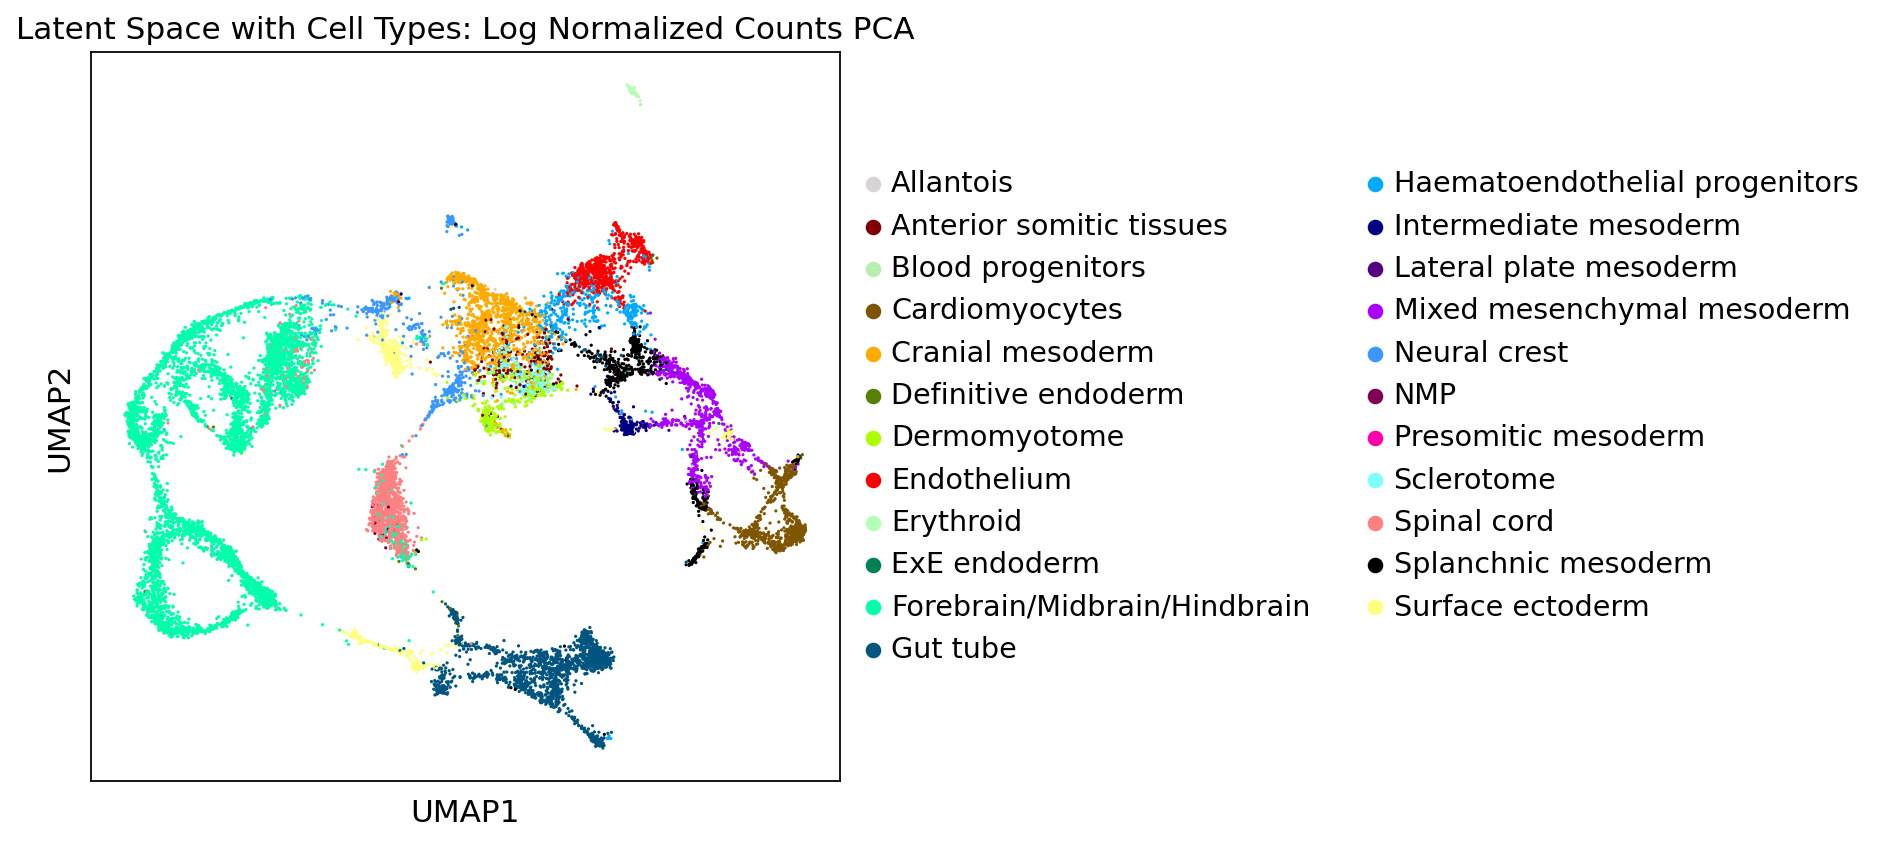

In [8]:
# Run PCA on log-normalized counts, then generate UMAP plot with cell type annotations
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=n_neighbors)
sc.tl.umap(adata, min_dist=0.3)
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 title="Latent Space with Cell Types: Log Normalized Counts PCA",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_log_normalized_counts_pca_cell_types_{current_timestamp}.png",
            bbox_inches="tight")

In [9]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=adata,
             resolution=leiden_resolution,
             random_state=random_seed,
             key_added=f"latent_log_normalized_counts_pca_leiden_{str(leiden_resolution)}")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


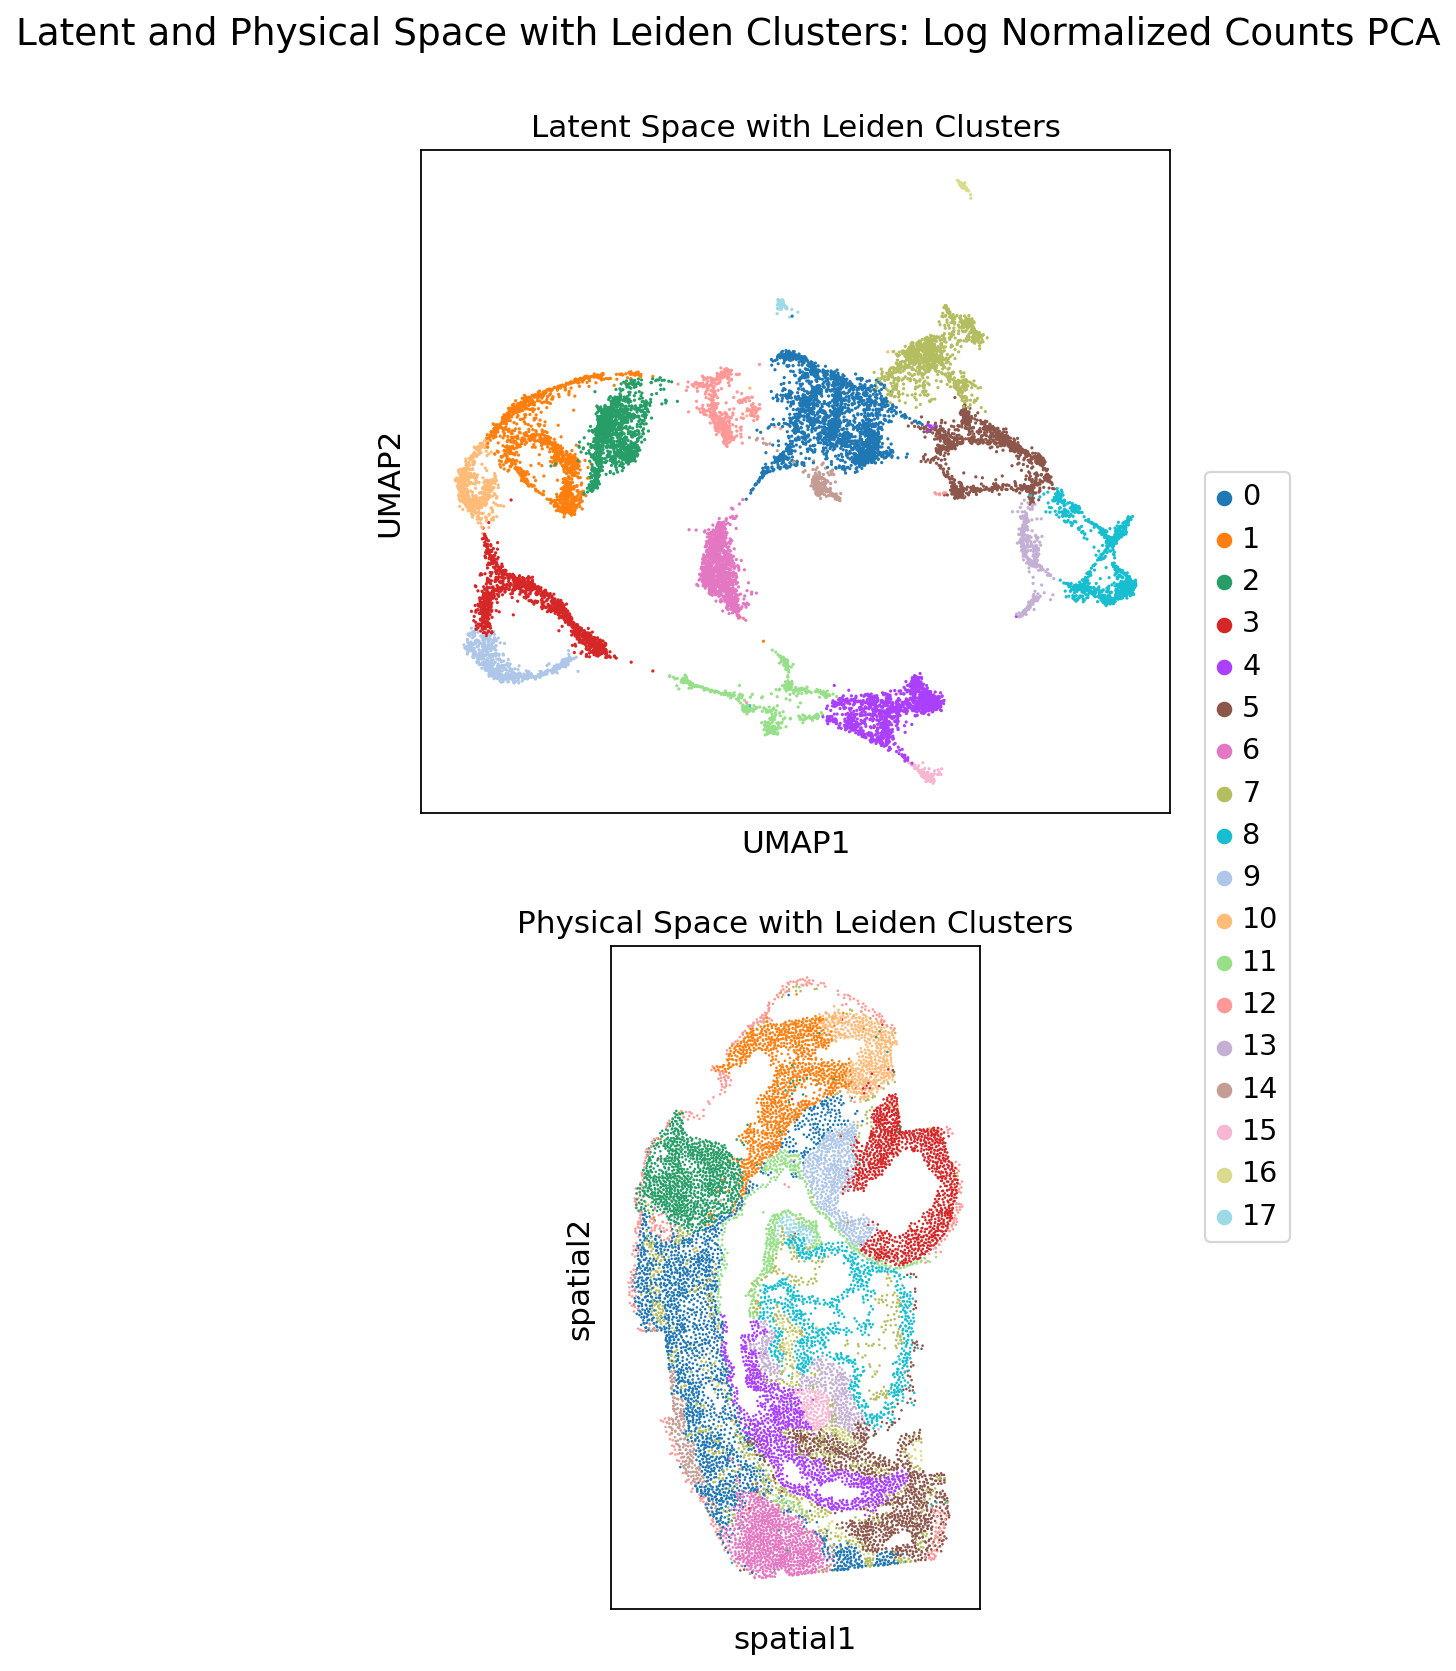

In [10]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: Log Normalized Counts PCA")
sc.pl.umap(adata=adata,
           color=[f"latent_log_normalized_counts_pca_leiden_{str(leiden_resolution)}"],
           title=f"Latent Space with Leiden Clusters",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_log_normalized_counts_pca_leiden_{str(leiden_resolution)}"],
              spot_size=0.03,
              title=f"Physical Space with Leiden Clusters",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.2)
fig.savefig(f"{figure_folder_path}/latent_physical_comparison_log_normalized_counts_pca_leiden_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

In [11]:
# Store X_pca as latent representation
adata.obsm[latent_key + "_run1"] = adata.obsm["X_pca"]

# Add sample as observation
adata.obs["sample"] = "embryo2"

# Label all 'gene programs' as active gene programs for subsequent benchmarking
adata.uns["pca_active_gp_names_run1"] = np.array([f"latent_{i}" for i in range(adata.obsm[latent_key + "_run1"].shape[1])])

# Store adata to disk
adata.write(f"{data_folder_path}/{dataset}_pca.h5ad")